# Курсовой проект для курса "Python для Data Science"

**Материалы к проекту (файлы)**:  
train.csv  
test.csv

**Задание**:  
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная**:  
Price

**Основная метрика**:  
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Вспомогательная метрика**:  
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

**Сдача проекта**:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

**Сроки сдачи**:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

**Примечание**:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Подготовительная часть

### Импортирование библиотек

In [24]:
import pandas as pd
import numpy as np

# import seaborn as sns
import matplotlib.pyplot as plt

### Настройка ноутбука

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Установка констант

In [3]:
RANDOM = 427

TRAIN_DATA_FILE = 'train.csv'
TEST_DATA_FILE = 'test.csv'

### Определение функций

In [4]:
def spec_transform_AB_to_int(df):
    ''' Преобразует признаки Ecology_2, Ecology_3, Shops_2 к числовому типу.
        Заменяет 'A' на 0, 'B' на 1.
    '''
    col_list = ['Ecology_2', 'Ecology_3', 'Shops_2']
    for col in col_list:
        df[col] = df[col].map({'A': 0, 'B': 1})


### Загрузка данных

In [5]:
data_train = pd.read_csv(TRAIN_DATA_FILE)

In [6]:
data_test = pd.read_csv(TEST_DATA_FILE)

## Анализ данных

Начнем с анализа вывода `info()`

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


В наборе данных data_train 10000 объектов. Два признака имеют пропуски. Три признака не числовые. Есть поля с идентификаторами.

Проверим как выглядит data_test

In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


В наборе данных data_test 5000 объектов. Те же самые признаки имеют пропуски.

Проанализируем вывод `describe()`

In [9]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Первое что бросается в глаза:  
**Rooms** - ноль и 19 комнат, вероятно ошибка, нужно разбираться  
**Square** - аномальные минимумы и максимумы, нужно разбиратья  
**LifeSquare** - аномальные минимумы и максимумы, нужно разбиратья. Это поле с пропусками и скорее всего сильно коррелирует с Square, поэтому пока оставим его.  
**KitchenSquare** - аномальные минимумы и максимумы. Максимум похож на год. Нужно разбираться.  
**Floor** - подозрительный 42 этаж, нужно проверить  
**HouseFloor** - подозрительный 117 этажный дом, нужно проверить  
**HouseYear** - аномальный максимум, явная опечатка, нужно исправлять  
**Ecology_1** - похоже на какую то оценку от 0 до 1  
**Social_1** - на первый взгляд аномалии не видно  
**Social_2** - на первый взгляд слишком большой максимум (похоже на год?)  
**Social_3** - аномально большой максимум, возможно пятибальную шкала?  
**Healthcare_1** - аномально большой максимум, Это поле с большим количеством пропусков. Скорее всего исключим его.  
**Helthcare_2** - на первый взгляд аномалий нет  
**Shops_1** - Похоже на количество магазинов, немного большое значение максимума, нужно проверить

Проверим строковые признаки

In [10]:
data_train.describe(include=['object'])

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


Все эти признаки бинарные. Посмотрим подробнее.

In [11]:
data_train['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [12]:
data_train['Ecology_3'].unique()

array(['B', 'A'], dtype=object)

In [13]:
data_train['Shops_2'].unique()

array(['B', 'A'], dtype=object)

Каждый из этих признаков можно привести к числовому заменив A на 0, B на 1.

Посмотрим на `describe()` для набора data_test

In [14]:
data_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Первичный анализ:
**Rooms** - ноль и 17 комнат, вероятно ошибка, нужно разбираться  
**Square** - аномальные минимумы и максимумы, нужно разбиратья  
**LifeSquare** - аномальные минимумы и максимумы, нужно разбиратья. Это поле с пропусками и скорее всего сильно коррелирует с Square, поэтому пока оставим его.  
**KitchenSquare** - аномальные минимумы и максимумы. Нужно разбираться.  
**Floor** - подозрительный 78 этаж, нужно проверить  
**HouseFloor** - подозрительный 99 этажный дом, нужно проверить  
**HouseYear** - на первый взгляд аномалий нет  
**Ecology_1** - похоже на какую то оценку от 0 до 1  
**Social_1** - на первый взгляд аномалии не видно  
**Social_2** - на первый взгляд слишком большой максимум (похоже на год?), точно такой же максимум есть и в data_train, проверить на привязку к району  
**Social_3** - аномально большой максимум, возможно пятибальную шкала? Точно такой же максимум есть и в data_train, проверить на привязку к району  
**Healthcare_1** - аномально большой максимум, Это поле с большим количеством пропусков. Скорее всего исключим его. Максимум такой же как и в data_train  
**Helthcare_2** - на первый взгляд аномалий нет  
**Shops_1** - Похоже на количество магазинов, немного большое значение максимума, нужно проверить. Точно такой же максимум есть и в data_train, проверить на привязку к району

Проверим строковые признаки

In [15]:
data_test.describe(include=['object'])

,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000
unique,2,2,2
top,B,B,B
freq,4952,4851,4588


Аналогично data_train

## Очистка данных

Приведем строковые признаки к числовому типу. Для этого напишем функцию, чтобы потом ее применить и для набора data_test.  
Воспользуемся ранее определенной функцией:

In [18]:
spec_transform_AB_to_int(data_train)

### Rooms

Посмотрим на распределение признака

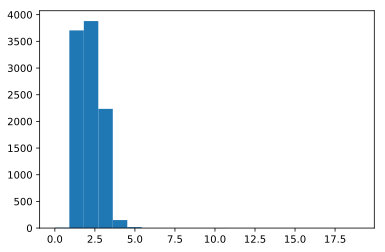

In [69]:
plt.hist(data_train['Rooms'], bins=21);

Подавляющее количество квартир лежит в диапазоне от 1 до 5 комнат.

Посмотрим на квартиры которые выбиваются из распределения:

In [115]:
data_train.loc[(data_train['Rooms'] == 0) | (data_train['Rooms'] > 5), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,1,1,74,19083,2,NaN,5,15,1,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,1,1,11,3097,0,NaN,0,0,1,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,1,1,264,0,NaN,0,1,1,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,NaN,0,1,1,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,1,1,66,10573,1,1322.0,3,8,1,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,1,1,30,6207,1,1183.0,1,0,1,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,NaN,0,0,1,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,1,1,43,8429,3,NaN,3,9,1,158998.110646


Их не много, попробуем привести количество комнат к нормальному исходя из площади квартиры. Чтобы это сделать, нужно убедиться, что сама площадь не имеет выбросов.

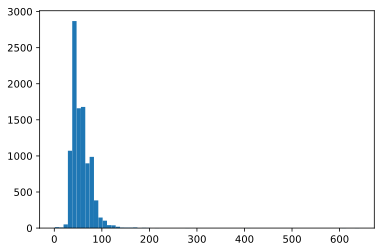

In [82]:
plt.hist(data_train['Square'], bins=70);

Помним, что у признака Square есть аномальные максимумы и минимумы. Попробуем найти адекватные минимумы и максимумы.

In [84]:
quantile_ = np.linspace(0, 1, 100)
square_ = []
for q in quantile_:
    square_.append(data_train['Square'].quantile(q))

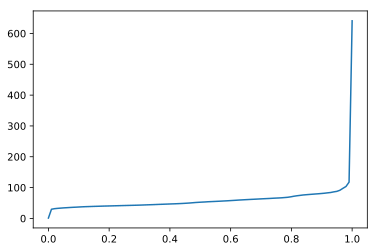

In [88]:
plt.plot(quantile_, square_);

В точках где график резко меняет свое направление и находятся наши адекватные минимум и максимум

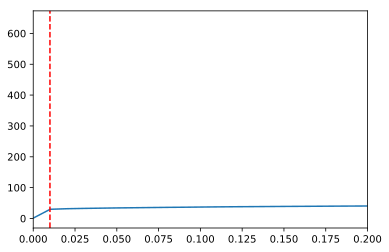

In [93]:
plt.plot(quantile_, square_)
plt.xlim(0, 0.2)
plt.axvline(0.01, color='Red', linestyle='--')
plt.show()

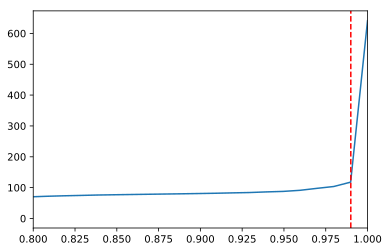

In [96]:
plt.plot(quantile_, square_)
plt.xlim(0.8, 1)
plt.axvline(0.99, color='Red', linestyle='--')
plt.show()

In [151]:
min_quantile = 0.01
min_adequate_square = data_train['Square'].quantile(min_quantile)
min_adequate_square

29.7197948840389

In [152]:
max_quantile = 0.99
max_adequate_square = data_train['Square'].quantile(max_quantile)
max_adequate_square

117.85611482113002

Определять значения квантилей будем вручную, а дальше напишем несколько функций.

Определили адекватные максимумы и минимумы. Теперь найдем среднее значение площади для квартир.

In [143]:
def calc_square_mean_by_rooms(data, min_q, max_q):
    ''' Считает среднюю площадь по квартирам. Отрезает выбросы по значению квантилей min_q и max_q
    '''
    min_square = data['Square'].quantile(min_q)
    max_square = data['Square'].quantile(max_q)
    square_mean = data[((data['Square'] >= min_square) & (data['Square'] <= max_square))
                     & ((data['Rooms'] >= 1) & (data['Rooms'] <= 5))].groupby(by='Rooms')['Square'].mean()
    return square_mean


In [153]:
square_mean = calc_square_mean_by_rooms(data_train, min_quantile, max_quantile)

In [154]:
square_mean

Rooms
1.0    41.361818
2.0    56.435144
3.0    75.665116
4.0    91.498567
5.0    91.701123
Name: Square, dtype: float64

In [124]:
for r, s in zip(square_mean.index.astype(int), square_mean):
    print(r, s)

1 41.362260230856975
2 56.43434679969454
3 75.66244242966457
4 91.52752748934574
5 91.70112330929977


In [125]:
def rooms_by_square(square):
    min_diff = abs(square - square_mean[1])
    room = 1
    for r, s in zip(square_mean.index.astype(int), square_mean):
        diff = abs(square - s)
        if diff < min_diff:
            min_diff = diff
            room = r
    return room


Заполним поле Rooms там где это нужно исходя из значения площади

In [140]:
data_train.loc[(data_train['Rooms'] == 0) | (data_train['Rooms'] > 5),
               'Rooms'] = data_train.loc[(data_train['Rooms'] == 0) | (data_train['Rooms'] > 5),
                                         'Square'].apply(rooms_by_square)

In [146]:
data_train['Rooms'].describe()

count    10000.000000
mean         1.888900
std          0.812787
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

### Square

Мы знаем наши адекватные максимумы и минимумы для площади квартир. Приведем все неадекватно большие и маленькие площади к их адекватным значениям.

In [155]:
def correct_square(data, min_adequate_square, max_adequate_square):
    data.loc[data['Square'] < min_adequate_square, 'Square'] = min_adequate_square
    data.loc[data['Square'] > max_adequate_square, 'Square'] = max_adequate_square


In [156]:
correct_square(data_train, min_adequate_square, max_adequate_square)

In [157]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888900,56.031491,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.812787,18.043003,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,29.719795,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,5.000000,117.856115,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


## Выбор модели

## Итоговое предсказание